In [10]:
import pandas as pd
import os
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Кластеризация и факторный анализ

Эта глава посвящена кластеризации и факторному анализу. Кластеризация близко подходит к методу k-ближайщих соседей, а факторный анализ предполагает анализ главных компонент. 

Кластеризация нацелена на разбиение данных по группам. Нечто подобное уже было, когда мы для логистической регрессии разбивали данные на группы. Отличие в том, что там использовались квантили только на одномерных данных. В данном же случае будут использованы более продвинутые способы, когда данные разбиваются на группы с позиции многомерных данных. 

Суть кластеризации в следующем. Произвольно назначаем центры. Далее считаем расстояние от ближайших точек к этим центрам на основании квадратичного расстояния. Например, дано четыре центра. До каждого считаем расстояние. Какое меньше, к такому и относим. Это образует кластеры. В каждом кластере считаем среднее – это новый центр. Пересчитываем расстояния, формируем кластеры. 

Если значения признаков непрерывные, то в качестве меры расстояния между объектами обычно используется расстояние Евклида, а если категориальные, то может использоваться расстояние Хэмминга.

In [4]:
data = pd.read_csv(os.getcwd() + '\\gd_clean_data.csv') 
db = data.copy()
db = db.drop(['title', 'language_code', 'authors', 'editions_count', 'year', 'quarter'], axis=1)
db.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count
0,3.59,501,4597666,94265
1,4.27,366,2530894,32871
2,3.80,277,2457092,43499


Вначале запустим кластеризацию на базовых настройках, произвольно выбрав кластеры. Часто используют 4-5 кластеров. Только после этого начнем диагностику модели.

Условия применения метода k-средних:

1) кластеры имеют форму круга;

2) признаки должны быть шкалированы;

3) группы сбалансированы, то есть имеют примерно одинаковое количество наблюдений.

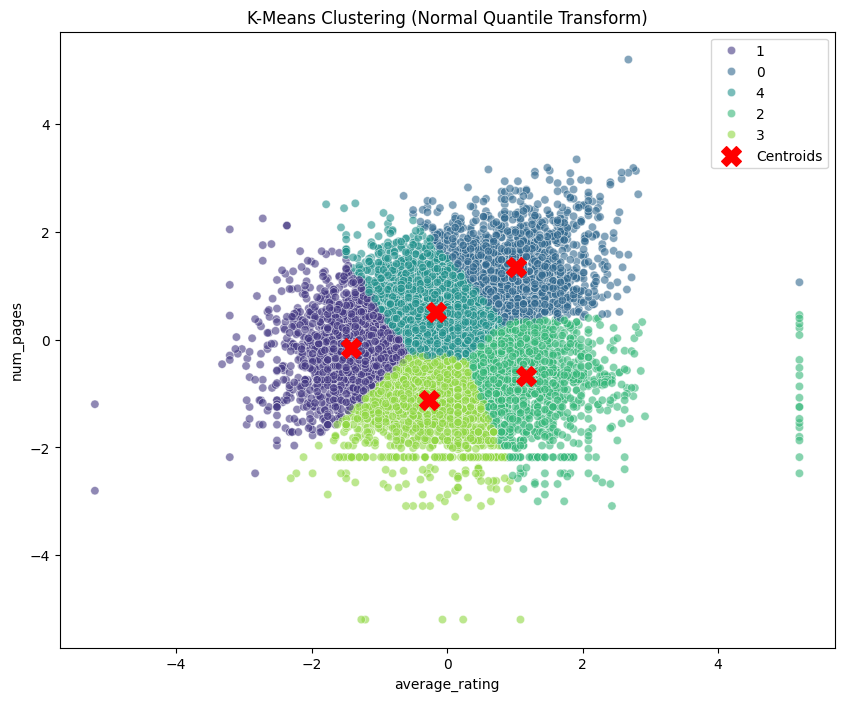

In [ ]:
# ==========================================
# 1. Трансформация
# ==========================================
db_scal = db.copy()
# Выбираем признаки для кластеризации
features_to_cluster = ['average_rating', 'num_pages']

# n_quantiles=1000: сохраняем топологию данных, избегаем огрубления
# output_distribution='normal': приводим к Гауссову распределению для K-Means
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)

# Трансформируем и сразу перезаписываем
X_transformed = scaler.fit_transform(db_scal[features_to_cluster])
db_scal[features_to_cluster] = X_transformed

# ==========================================
# 2. Кластеризация
# ==========================================
db_k = db_scal.copy()

# init='k-means++': "умная" инициализация центроидов (ускоряет сходимость)
# n_init='auto': подавляет предупреждения (будущий стандарт)
kmeans = KMeans(n_clusters=5, init='k-means++', n_init='auto', random_state=42)

# fit_predict делает обучение и предсказание за один проход
db_k['labels'] = kmeans.fit_predict(X_transformed).astype(str)

# ==========================================
# 3. Визуализация
# ==========================================
plt.figure(figsize=(10, 8))

# Рисуем точки данных
sns.scatterplot(
    x='average_rating', 
    y='num_pages', 
    data=db_k, 
    hue='labels', 
    palette='viridis',
    alpha=0.6
)

# Рисуем центроиды
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0], 
    centers[:, 1], 
    c='red', 
    s=200, 
    marker='X', 
    label='Centroids'
)

plt.title('K-Means Clustering (Normal Quantile Transform)')
plt.legend()
plt.show()

На этом графике на осях – стандартные отклонения, от -4 до +4. На оси average_rating слева – низкие оценки, справа – высокие. На оси num_pages снизу – книги с маленьким количеством страниц, сверху – книги с большим количеством страниц. На самом графике мы видем пять групп книг. Данные сгруппированы так, что в каждой группе для каждого наблюдения расстояние до центра группы, помеченного красным крестиком, меньше, чем до центра другой группы. Другими словами, мы разбили книги на классы. Какие же классы книг мы получили?

Фиолетовый кластер. Эти книги имеют низкие оценки, но среднее количество страниц. 

Светло-зеленый кластер. Центр этой группы лежит ниже нулевого стандартного отклонения, количество страниц в этих книгах меньше среднего. Однако оценки таких книг тоже средние. Такие книги редко оценивают низко, поэтому только меньшая часть группы приближается к фиолетовому кластеру.

Синий кластер. Эти книги выше среднего как по оценкам, так и по количеству страниц. Это довольно разреженная группа, здесь много киг, у котороых количество страниц значительно отличается от среднего, причем значительно в положительную сторону отличается и оценка. Возможно, что читатели, раз они одолели более 800 страниц текста, склонны положительно оценивать книгу.

Зеленый кластер. Книги со средним количеством страниц и средней оценкой, своего рода стандарт.

Бирюзовый кластер. Самый плотный кластер. Средний рейтинг, средний объем. Большинство книг попадает сюда.

Это можно получить и в табличной форме. Давайте сразу добавим и другие переменные.

In [7]:
# 1. Берем исходный датафрейм (где реальные числа)
# Убедитесь, что 'db' - это ваша оригинальная таблица
db_real = db.copy()

# 2. Добавляем метки кластеров, которые нашла модель
# Важно: порядок строк не менялся, поэтому можно просто присвоить
db_real['cluster_label'] = kmeans.labels_

# 3. Группируем и смотрим средние (и медианы, так надежнее)
stats = db_real.groupby('cluster_label')[['num_pages', 'average_rating', 'ratings_count']].agg(['mean', 'median'])

# 4. Красивый вывод
stats.round(2)

num_pages        average_rating        ratings_count        
                   mean median           mean median          mean  median
cluster_label                                                             
0                674.47  592.0           4.22   4.21      29424.49  1178.0
1                283.39  272.0           3.50   3.56      10092.49   461.5
2                208.11  208.0           4.26   4.22      18937.16   861.0
3                148.09  159.0           3.88   3.89      14125.18   416.0
4                400.92  372.0           3.91   3.92      22980.50  1879.0

Любопытно, что самая высокая оценка в 4.26 у книг, у которых количество страниц всего 208. Правда, у книг с самой низкой оценкой в 3,50 страниц не сильно больше, всего 272.

Попробуем анализ главных компонент, чтобы схлопнуть признаки. За анализой главных компонент стоит любопытная математика, но излагать здесь мы ее не будем. Чтобы пояснить смысл такого анализа, мы предложим образ. Представьте многоквартирный дом. Он трехмерный? Да. И вот мы хотим этот трехмерный дом поместить на двухмерный график, но так, чтобы не потерять важные детали. Примерно этим занимаются кадастровые инженеры. Как же это сделать?

Давайте "взлетим" над домом, будем смотреть на него сверху. Предположим, что мы видим сквозь перегородки, перекрытия и т.п. Итак, смотрим на дом сверху, теперь от каждой значимой точки на каждом этаже проводим перпендикуляр. На что? На площадь под домом. А эта площадь - двухмерная. Делаем так для каджой точки. В итоге у нас трехмерный объект окажется "закодирован" в двухмерном пространстве. 

Примерно в этом и задача анализа главных компонент. Надо найти такие "меньшие" размерности, на которых отражен максимум информации из нашей исходной размерности. Вот как это выглядит в коде. 

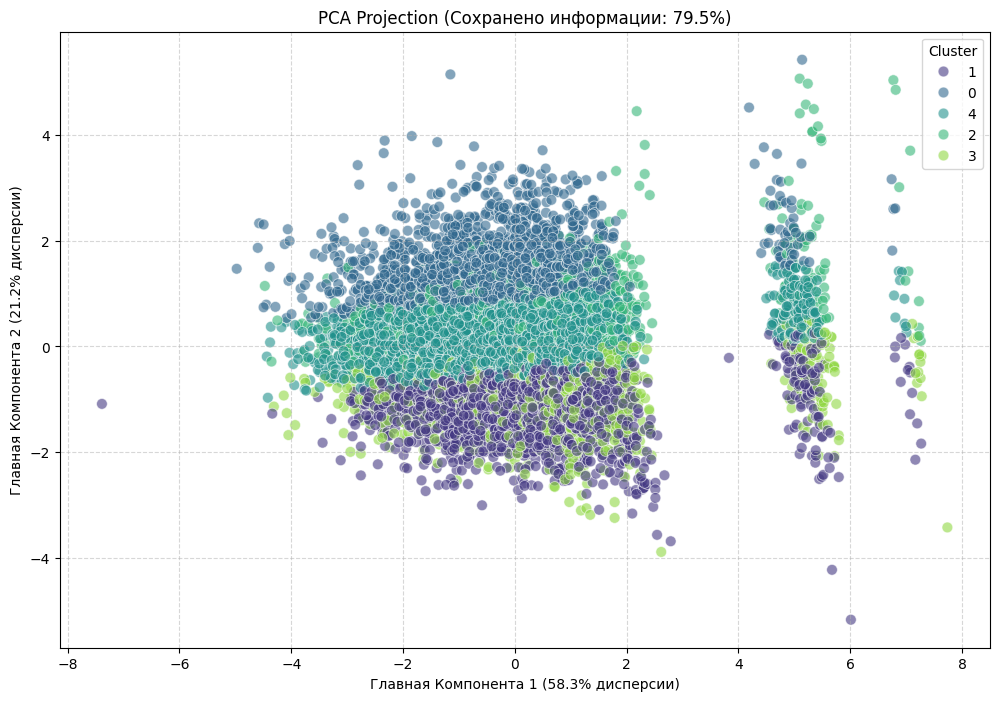


--- МАТРИЦА НАГРУЗОК (Что означают оси?) ---
                     PC1   PC2
average_rating     -0.03  0.80
num_pages          -0.13  0.59
ratings_count      -0.55 -0.00
text_reviews_count -0.82 -0.13


In [11]:
# ==========================================
# 1. Подготовка данных (Feature Selection)
# ==========================================
# Берем все числовые характеристики книги.
# PCA найдет скрытые связи между ними (например, между ratings_count и text_reviews_count).
full_features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']

# Используем исходный датафрейм (db или db_real), где лежат сырые числа
# Убедитесь, что в db_real есть колонка 'cluster_label' из предыдущего шага (K-Means)
data_for_pca = db_real[full_features].copy()

# ==========================================
# 2. Трансформация (Normal Distribution)
# ==========================================
# PCA максимизирует дисперсию. Если одно распределение "экспоненциальное", а другое "нормальное",
# PCA будет искажен. Приводим всё к Гауссу.
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_transformed = scaler.fit_transform(data_for_pca)

# ==========================================
# 3. PCA (Сжатие 4D -> 2D)
# ==========================================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_transformed)

# Сохраняем результаты в DataFrame для графика
df_viz = db_real.copy()
df_viz['PC1'] = X_pca[:, 0]
df_viz['PC2'] = X_pca[:, 1]
# Превращаем метки в строки, чтобы seaborn раскрасил их дискретными цветами
df_viz['cluster_label'] = df_viz['cluster_label'].astype(str)

# ==========================================
# 4. Визуализация
# ==========================================
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='cluster_label', 
    data=df_viz, 
    palette='viridis', 
    alpha=0.6,
    s=60 # размер точек
)

# Добавляем информацию о потерях данных
var_expl = pca.explained_variance_ratio_
plt.title(f'PCA Projection (Сохранено информации: {var_expl.sum():.1%})')
plt.xlabel(f'Главная Компонента 1 ({var_expl[0]:.1%} дисперсии)')
plt.ylabel(f'Главная Компонента 2 ({var_expl[1]:.1%} дисперсии)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Cluster')
plt.show()

# ==========================================
# 5. Интерпретация осей (Матрица нагрузок)
# ==========================================
print("\n--- МАТРИЦА НАГРУЗОК (Что означают оси?) ---")
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=full_features
)
print(loadings.round(2))

Мы видим, что по оси PC1, то есть по оси x, у нас главное влияния у text_reviews_count, причем average_rating практически не играет роли. На второй оси PC2, то есть оси y, у нас главное влияние уже у average_rating. Таким образом, у нас text_reviews_count и average_rating независимы. Любопытно, что по оси y вклад ratings_count вообще нулевой.